# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [5]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [6]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

In [8]:
yprob_full.shape

(300,)

## 3) Metrics at Threshold 0.5

In [15]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5

# Definitions:
# Accuracy: proportion of total predictions that are correct, calculated as (number correct predictions) / (total predictions).
# Precision: proportion of positive identifications that were actually correct, calculated as (true positives) / (true positives + false positives).
# Recall: proportion of actual positives that were identified correctly, calculated as (true positives) / (true positives + false negatives).

# Using full set of features (CAPE, PWAT, shear)
acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full, zero_division=0)
rec_full = recall_score(yf_test, ypred_full, zero_division=0)

print(f"Full model - Accuracy: {acc_full:.3f}, Precision: {prec_full:.3f}, Recall: {rec_full:.3f}")

# Using reduced set of features (CAPE only)
acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced, zero_division=0)
rec_reduced = recall_score(yr_test, ypred_reduced, zero_division=0)

print(f"Reduced model - Accuracy: {acc_reduced:.3f}, Precision: {prec_reduced:.3f}, Recall: {rec_reduced:.3f}")


Full model - Accuracy: 0.723, Precision: 0.733, Recall: 0.678
Reduced model - Accuracy: 0.717, Precision: 0.736, Recall: 0.651


<Figure size 640x480 with 0 Axes>

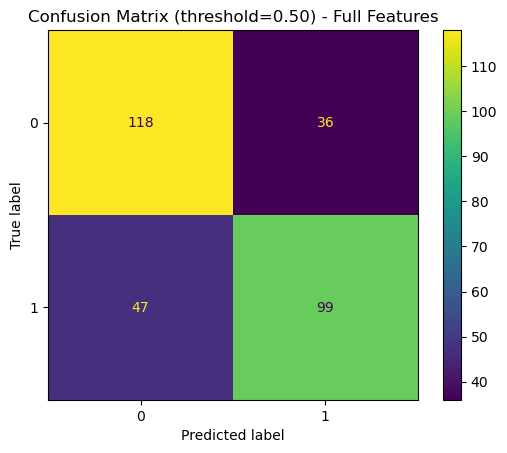

<Figure size 640x480 with 0 Axes>

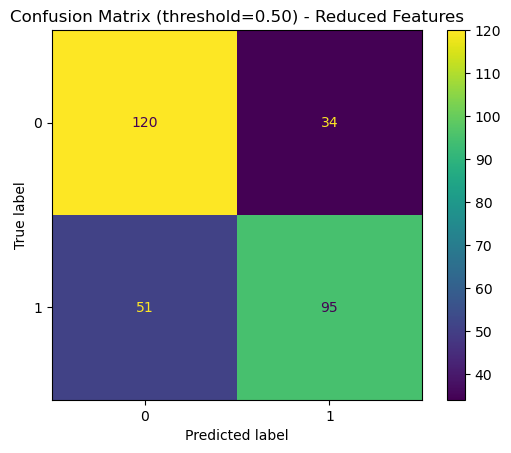

In [ ]:
# Plot Confusion Matrix for full feature model - just to see the differences
from sklearn.metrics import ConfusionMatrixDisplay

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(yf_test, ypred_full)
plt.title(f"Confusion Matrix (threshold={thr:.2f}) - Full Features")
plt.show()

# Plot Confusion Matrix for reduced feature model
fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(yr_test, ypred_reduced)
plt.title(f"Confusion Matrix (threshold={thr:.2f}) - Reduced Features")
plt.show()

## 4) Plot ROC and Precision–Recall Curves

/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


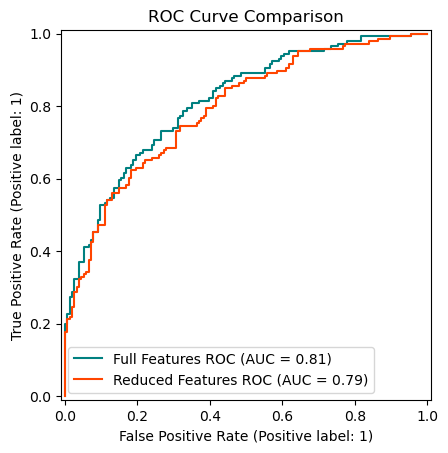

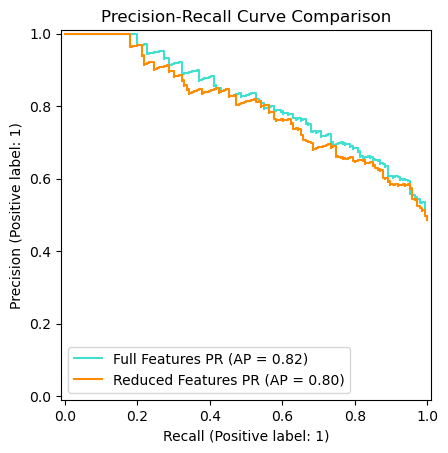

In [18]:
# TODO: Plot ROC and PR curves for both models on shared axes

# ROC curves:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(yf_test, yprob_full, name='Full Features ROC', ax=ax, color='teal')
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, name='Reduced Features ROC', ax=ax, color='orangered')
ax.set_title("ROC Curve Comparison")
ax.legend()
plt.show()

# PR curves:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, name='Full Features PR', ax=ax, color='turquoise')
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, name='Reduced Features PR', ax=ax, color='darkorange')
ax.set_title("Precision-Recall Curve Comparison")
ax.legend()
plt.show()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
   <span style="color:DarkCyan; font-weight:bold">
   __<u>Answer</u>__:  _The full-featured model has higher AUCs for both ROC and PR, which implies that it is the superior model. However, the difference is_ __slight__, _which suggests that PWAT and shear do not provide significant additional predictive capability. CAPE is the variable with the greatest influence on the event outcome._
   </span>

2. Compare **accuracy**, **precision**, and **recall** for both models.  
<span style="color:DarkCyan; font-weight:bold">
__<u>Answer</u>__:  
_Full model    - Accuracy: 0.723, Precision: 0.733, Recall: 0.678_  
_Reduced model - Accuracy: 0.717, Precision: 0.736, Recall: 0.651_
   - Which model would you choose to **maximize event detection** (recall)?  
   <span style="color:DarkCyan; font-weight:bold">
   __<u>Answer</u>__:  _Recall is highest for the full-features model. If you're concerned about avoiding false-negatives (misses), the full-features model is the best choice._
   </span>

   - Which model would you choose to **minimize false alarms** (precision)?  
   <span style="color:DarkCyan; font-weight:bold">
   __<u>Answer</u>__:  _Precision is very slightly higher for the reduced-features model. If you're concerned about minimizing false-alarms, the reduced-features model is the better choice. It wouldn't make much difference, though. The difference in the precision between these two models is 0.003._
   </span>